# DIVAnd full analysis

This notebook presents the different steps necessary for the creation of a climatology:
1. ODV data reading.
2. Extraction of bathymetry and creation of mask
3. Data download from other sources and duplicate removal.
4. Quality control.
5. Parameter optimisation.
6. Spatio-temporal interpolation with `DIVAnd`.

In [1]:
using divand
using PyPlot
using NCDatasets
using PhysOcean
using DataStructures

# Load a more efficient version of sparse matrix multiplication
include(joinpath(Pkg.dir("divand"),"src","override_ssmult.jl"))

## Configuration
* Define the horizontal, vertical and temporal resolutions.
* Select the variable

In [2]:
dx, dy = 0.125, 0.125
lonr = 11.5:dx:20
latr = 39:dy:46
timerange = [Date(1950,1,1),Date(2017,12,31)];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = [0.,20.,50.];

varname = "Salinity"
yearlist = [1900:2017];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];

In [3]:
TS = divand.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = divand.TimeSelectorYearListMonthList(UnitRange{Int64}[1900:2017], Array{Int64,1}[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])


## 1. Read your ODV file
Adapt the `datadir` and `datafile` values.

In [4]:
datadir = "./Adriatic/"
datafile = joinpath(datadir, "AdriaticSea_SDC.txt")

"./Adriatic/AdriaticSea_SDC.txt"

Depending on the size of your file, this step can take up to a few minutes.

In [5]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = ODVspreadsheet.load(Float64,[datafile],
                           ["Water body salinity"]; nametype = :localname );

INFO: No. of columns: 128
INFO: Total no. of lines: 2085035
INFO: No. of profiles in the file: 34709


207.514136 seconds (894.65 M allocations: 45.806 GiB, 43.88% gc time)


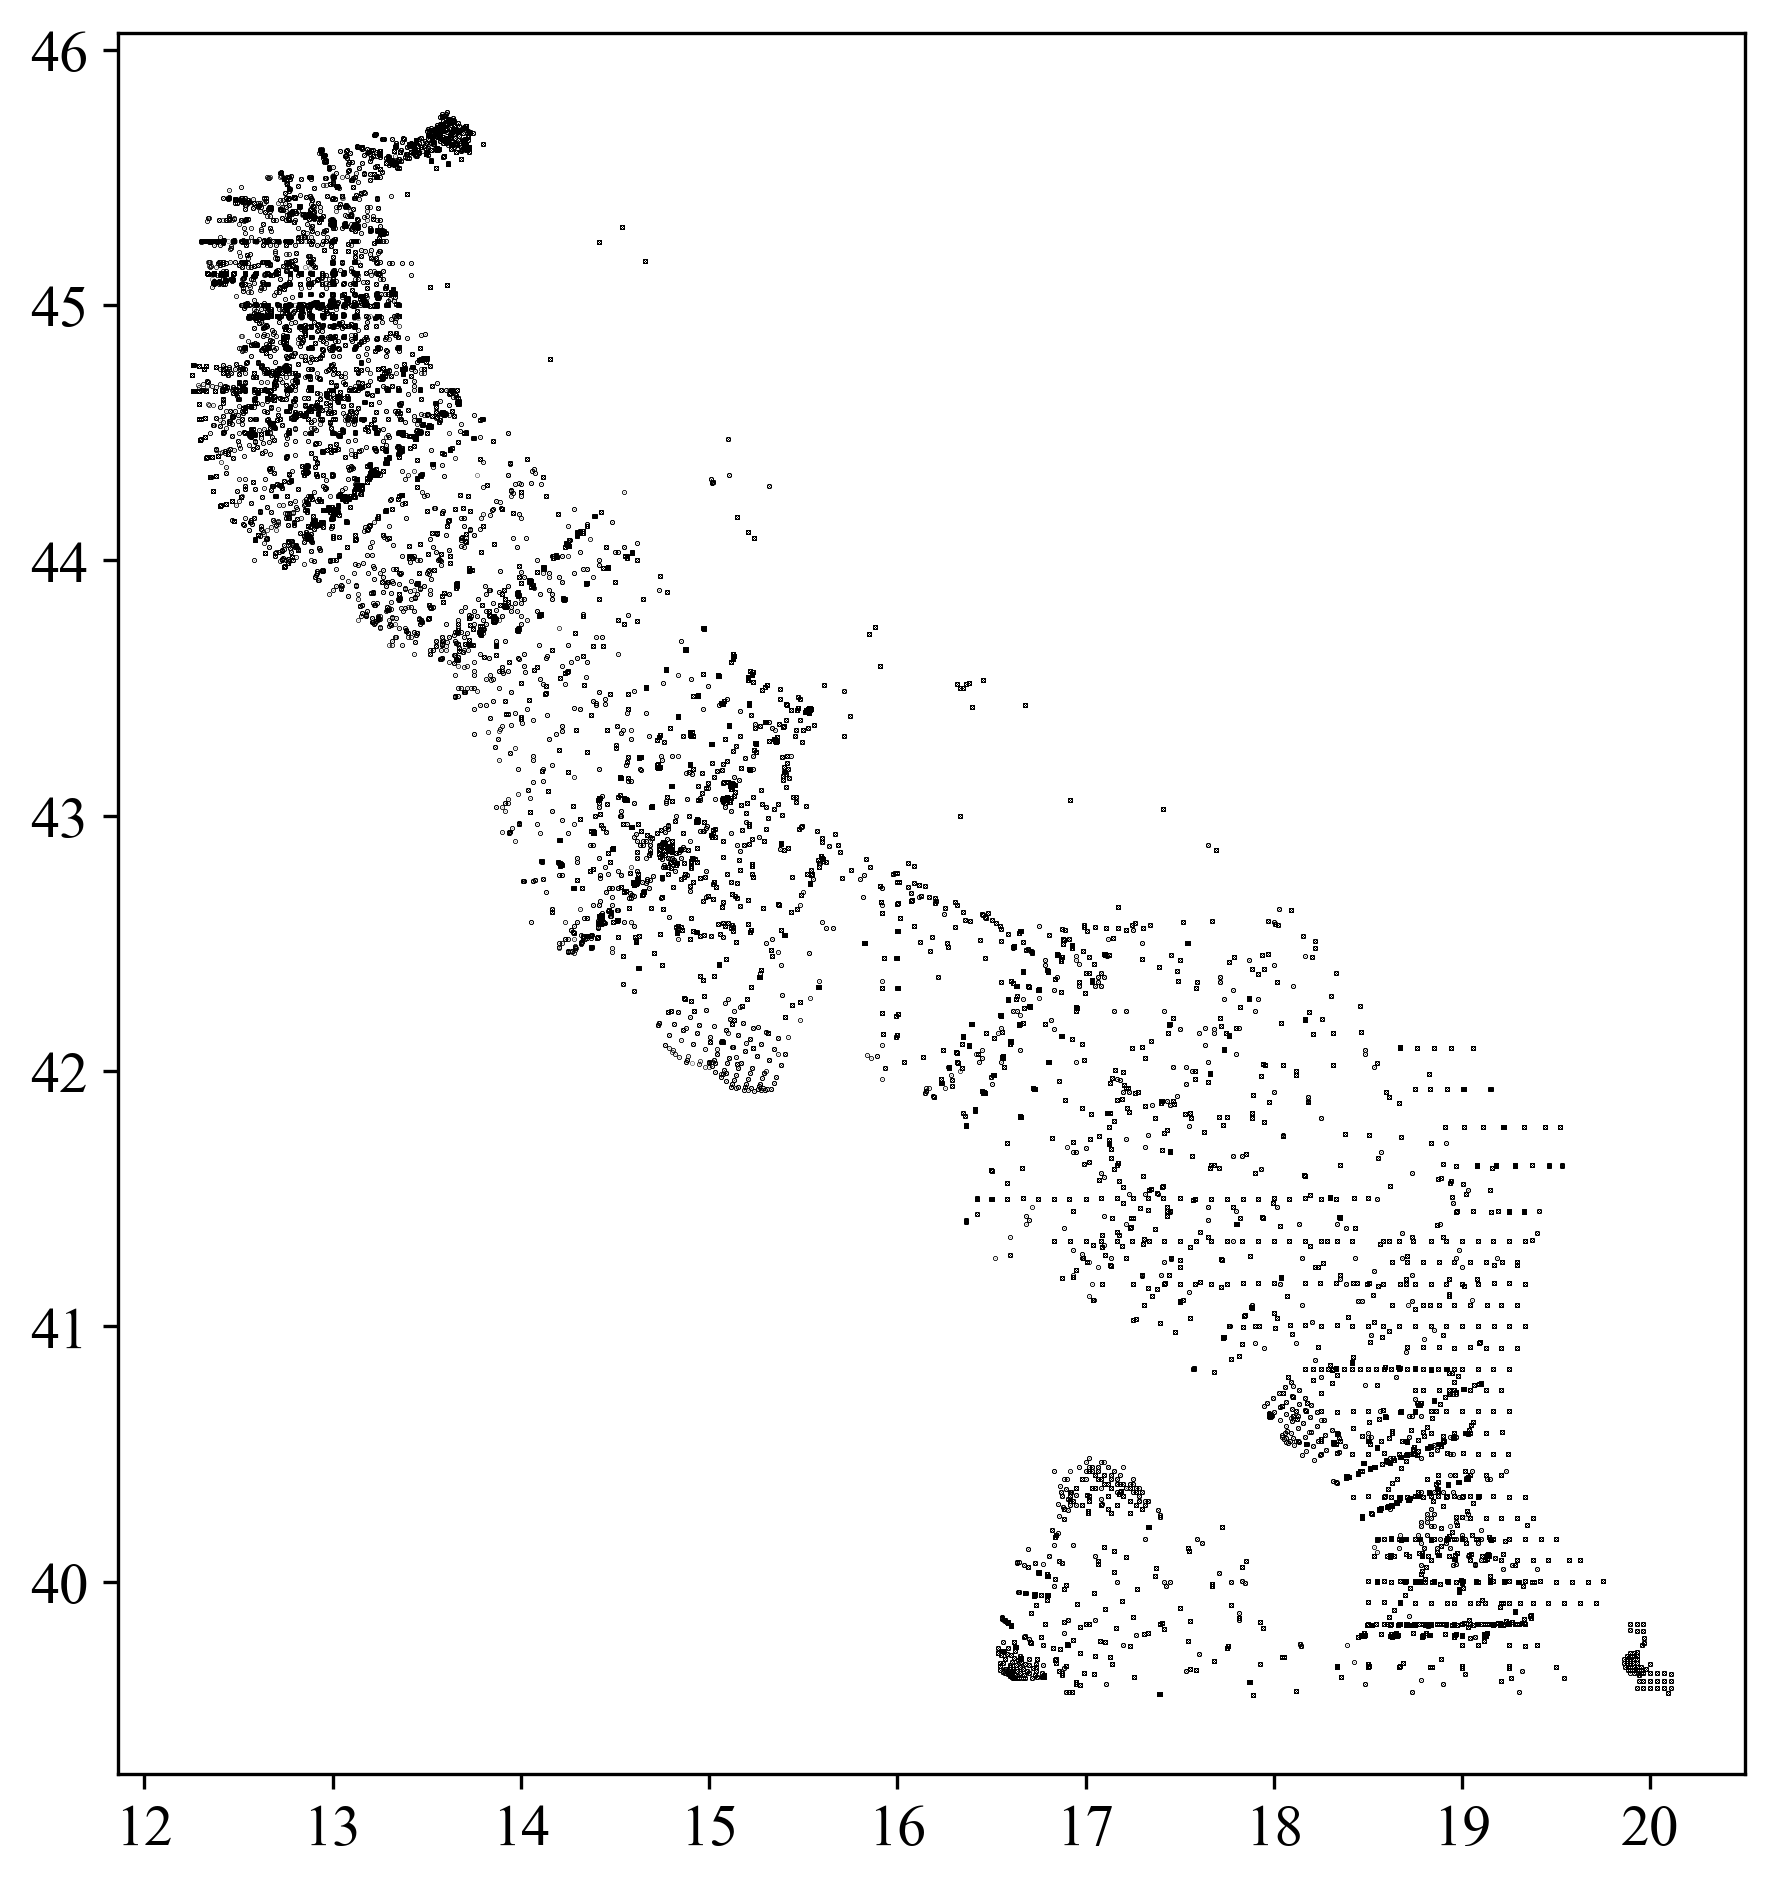

In [6]:
figure(figsize=(7, 70))
plot(obslon, obslat, "ko", markersize=.1)
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca()[:set_aspect](aspect_ratio)

In [7]:
# Garbage collect
gc()

In [8]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (12.25017, 20.11)
              minimum and maximum of obs. dimension 2: (39.55676, 45.755)
              minimum and maximum of obs. dimension 3: (0.0, 1484.203)
              minimum and maximum of obs. dimension 4: (1911-08-17T09:24:00, 2015-02-10T10:43:00)
                          minimum and maximum of data: (4.07, 40.880001)


## 2. Extract the bathymetry
### 2.1 Choice of bathymetry
Modify `bathname`

In [9]:
bathname = "gebco_30sec_8.nc"
if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

INFO: Bathymetry file already downloaded


In [10]:
bx,by,b = load_bath(bathname,true,lonr,latr);

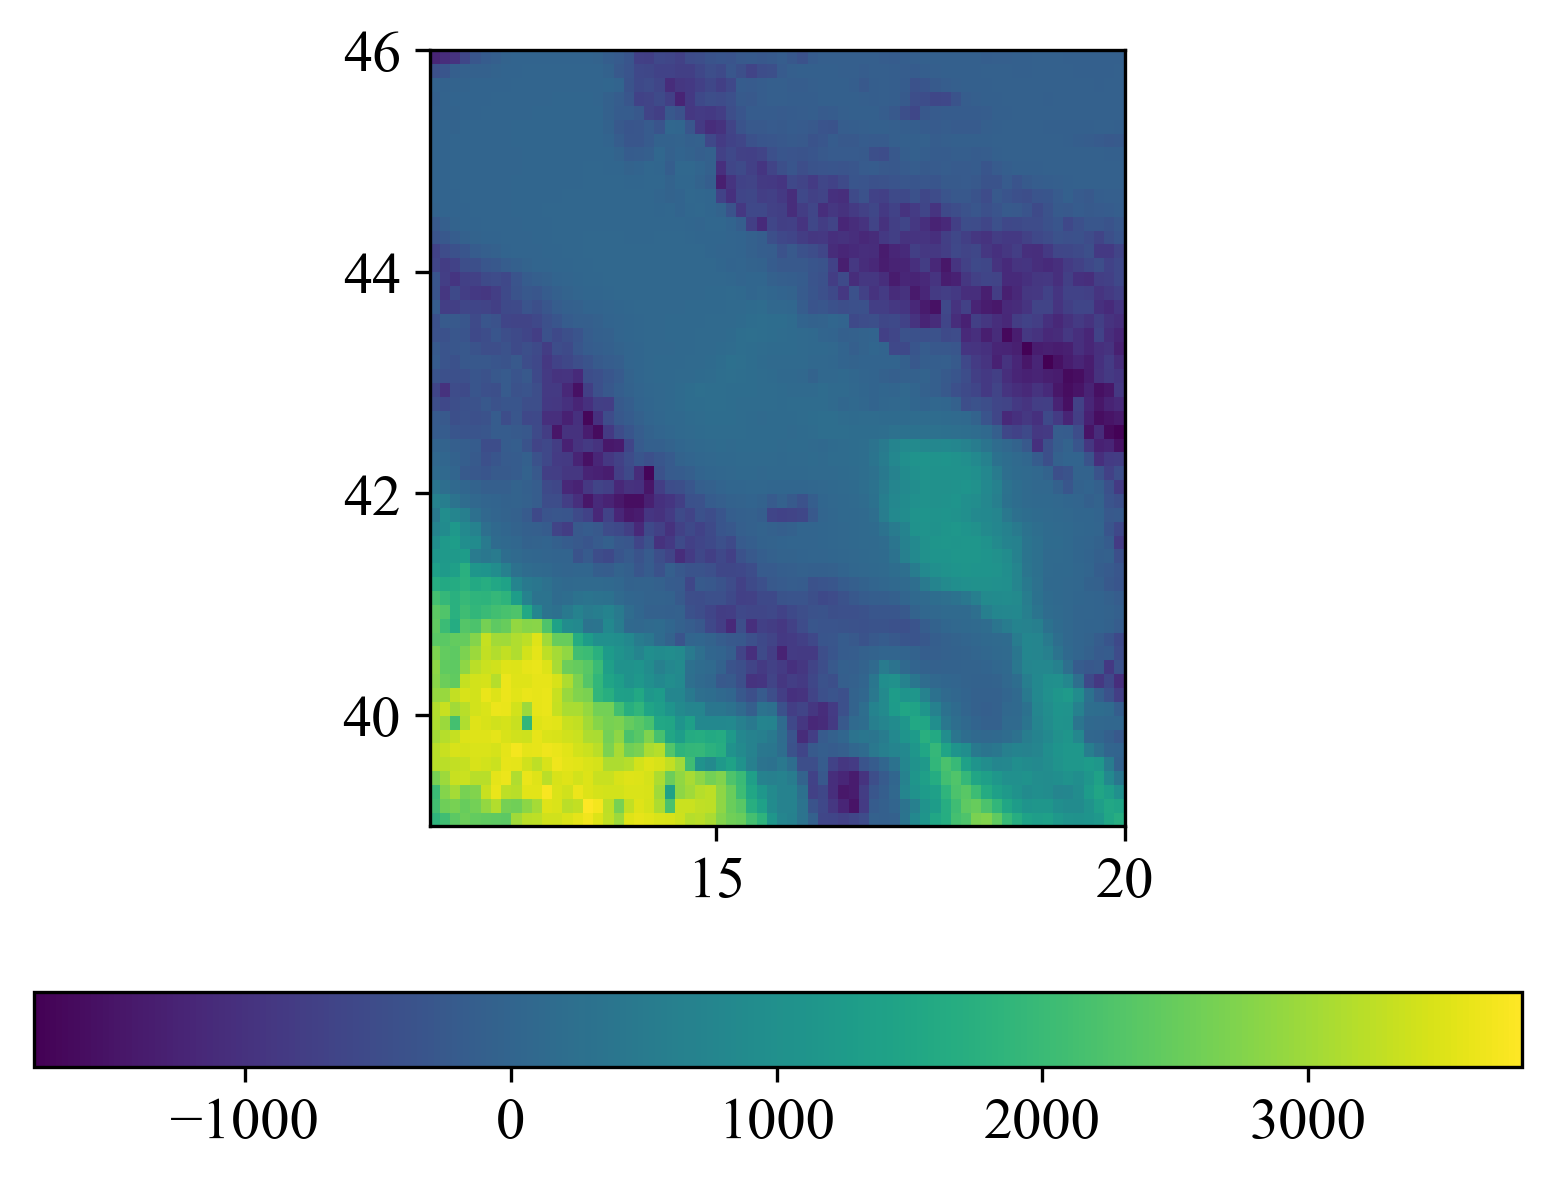

In [11]:
pcolor(bx,by,b'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](aspect_ratio)

### 2.2 Create mask

In [12]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (69, 57, 3)


(69, 57, 3)

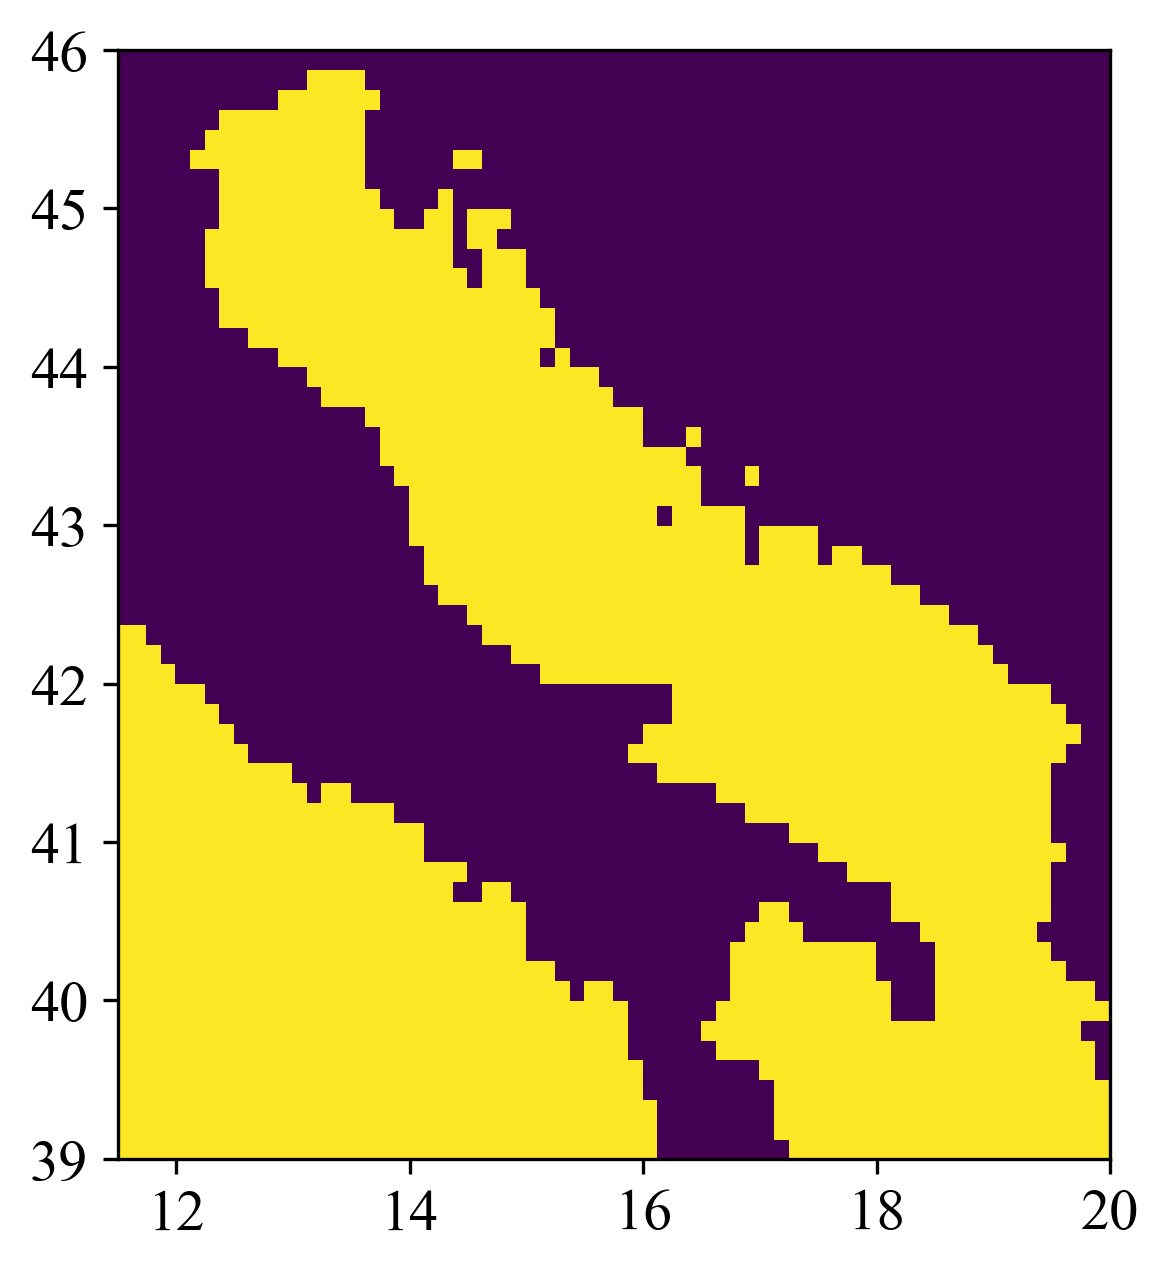

In [13]:
pcolor(bx,by,Float64.(mask[:,:,1])'); 
gca()[:set_aspect](aspect_ratio)

### 2.3 Edit the mask
As an example we will remove the Mediterranean Sea from the domain.

In [14]:
grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];

In [15]:
mask_edit = copy(mask);
sel_mask1 = (grid_by .<=42.6) .& (grid_bx .<= 14.);
sel_mask2 = (grid_by .<=41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;

In [16]:
@show size(mask_edit)

size(mask_edit) = (69, 57, 3)


(69, 57, 3)

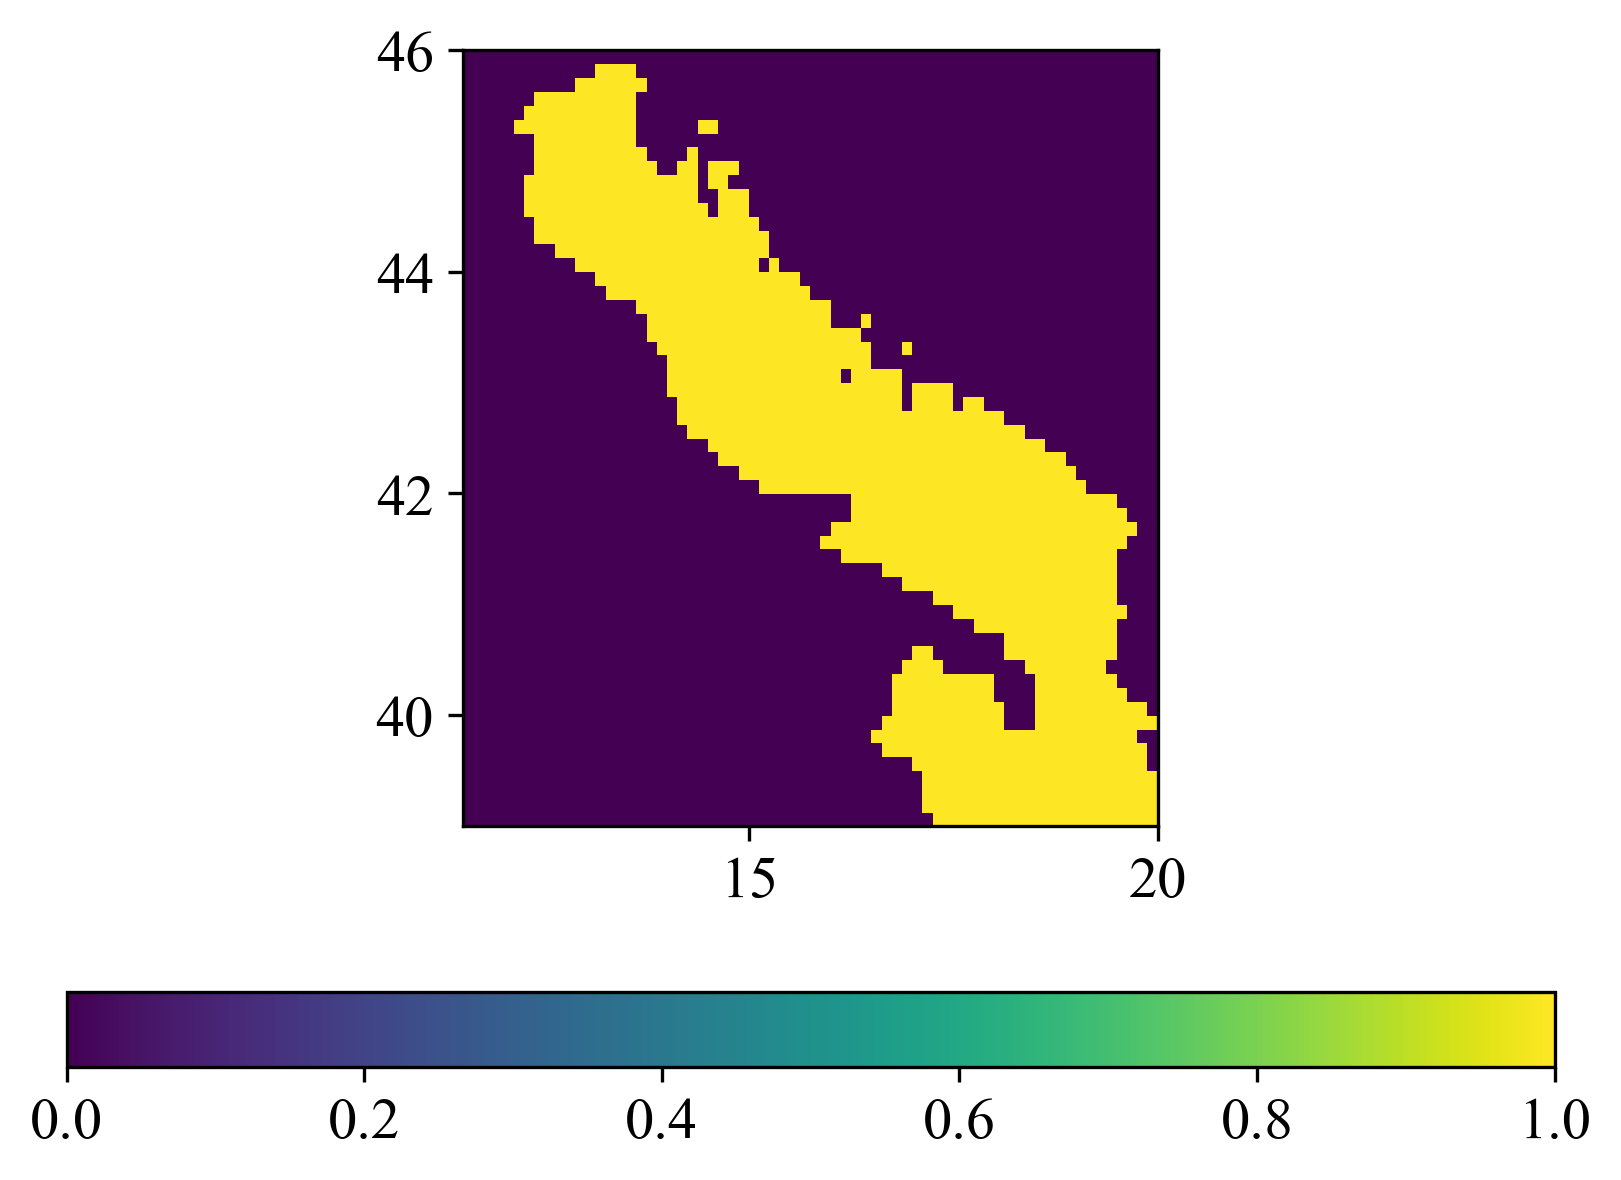

In [17]:
pcolor(bx, by, Float64.(mask_edit[:,:,1])'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](aspect_ratio)

## 3. Extract data from other sources
### 3.1 World Ocean Database

In [18]:
# Configuration
email = "your-mail@domain"
woddatadir = "./Adriatic/WOD/"
mkpath(woddatadir);

In [19]:
# Uncomment the next line if you have to download the data
# WorldOceanDatabase.download(lonr,latr,timerange,varname,email,woddatadir);

Read the data. This can also take up to a few minutes.

In [20]:
obsvalwod,obslonwod,obslatwod,obsdepthwod,obstimewod,obsidwod = 
WorldOceanDatabase.load(Float64,woddatadir,varname);

Remove the data outside Adriatic (similar to mask editing)

In [21]:
sel_data1 = (obslatwod .<= 42.6) .& (obslonwod .<= 14.);
sel_data2 = (obslatwod .<= 41.2) .& (obslonwod .<= 16.2);
ndataremove = sum((sel_data1) .| (sel_data2))
sel_data = .~((sel_data1) .| (sel_data2));

obslatwod = obslatwod[sel_data];
obslonwod = obslonwod[sel_data];
obsdepthwod = obsdepthwod[sel_data];
obstimewod = obstimewod[sel_data];
obsvalwod = obsvalwod[sel_data];
obsidwod = obsidwod[sel_data];

info("Number of removed WOD data: $ndataremove");

INFO: Number of removed WOD data: 96294


Simple plot to check the positions from both datasets:

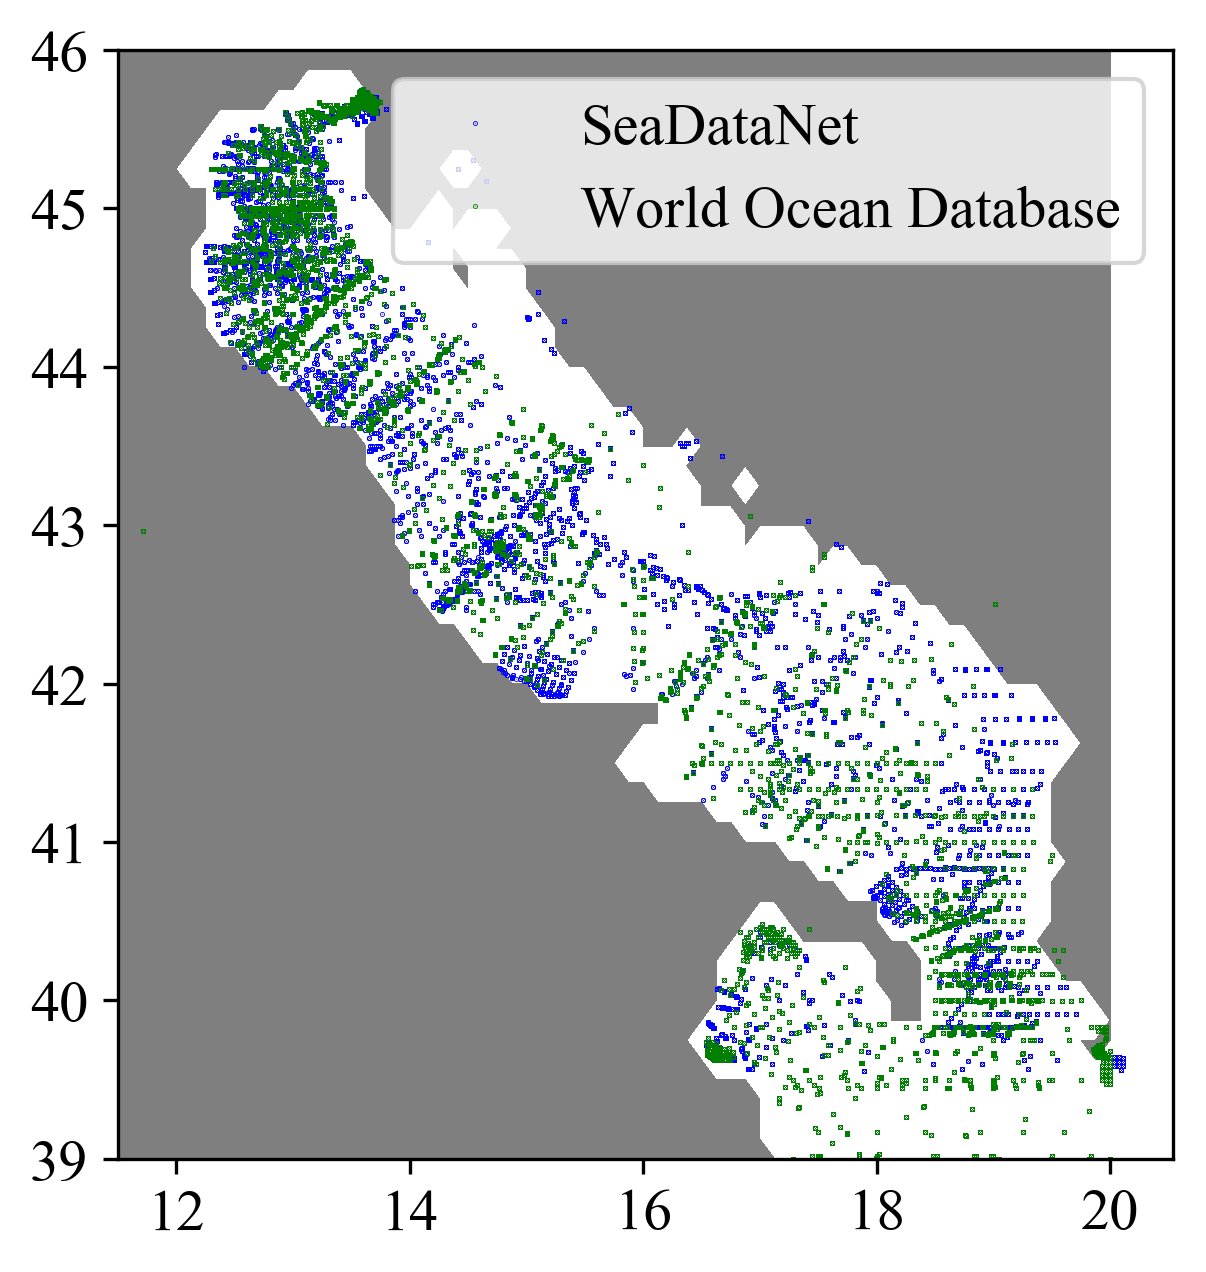

In [22]:
figure()
contourf(bx, by, Float64.(mask_edit[:,:,1])',
    levels=[-1e5,0],cmap="binary"); 
plot(obslon, obslat, "bo", markersize=.2, 
    label="SeaDataNet")
plot(obslonwod, obslatwod, "go", markersize=.2, 
    label="World Ocean Database");
gca()[:set_aspect](aspect_ratio)
legend();

### 3.2 Extract from another source (optional)
Add here the code to read data from another file.

### 3.3 Remove duplicates
Criteria (to adapt):
* Horizontal distance: 0.01 degree (about 1km)
* Vertical separation: 0.01 m depth
* Time separarion: 1 minute.      
* Salinity difference is 0.01 psu.

In [23]:
dupl = divand.Quadtrees.checkduplicates(
    (obslon,obslat,obsdepth,obstime), obsval, 
    (obslonwod,obslatwod, obsdepthwod, obstimewod), obsvalwod,
    (0.01,0.01,0.01,1/(24*60)),0.01);

Find the indices of the possible duplicates:

In [24]:
index = find(.!isempty.(dupl));
ndupl = length(index);
pcdupl = round(ndupl / length(obslon) * 100, 2);
info("Number of possible duplicates: $ndupl")
info("Percentage of duplicates: $pcdupl%")

INFO: Number of possible duplicates: 803047
INFO: Percentage of duplicates: 56.13%


If you decide to combine the 2 (or more) datasets:

In [25]:
newpoints = find(isempty.(dupl));
info("Number of new points: " * string(length(newpoints)))
obslon = [obslon; obslonwod[newpoints]];
obslat = [obslat; obslatwod[newpoints]];
obsdepth = [obsdepth; obsdepthwod[newpoints]];
obstime = [obstime; obstimewod[newpoints]];
obsval = [obsval; obsvalwod[newpoints]];
obsid = [obsid; obsidwod[newpoints]];

INFO: Number of new points: 375062


Create a plot showing the additional data points:

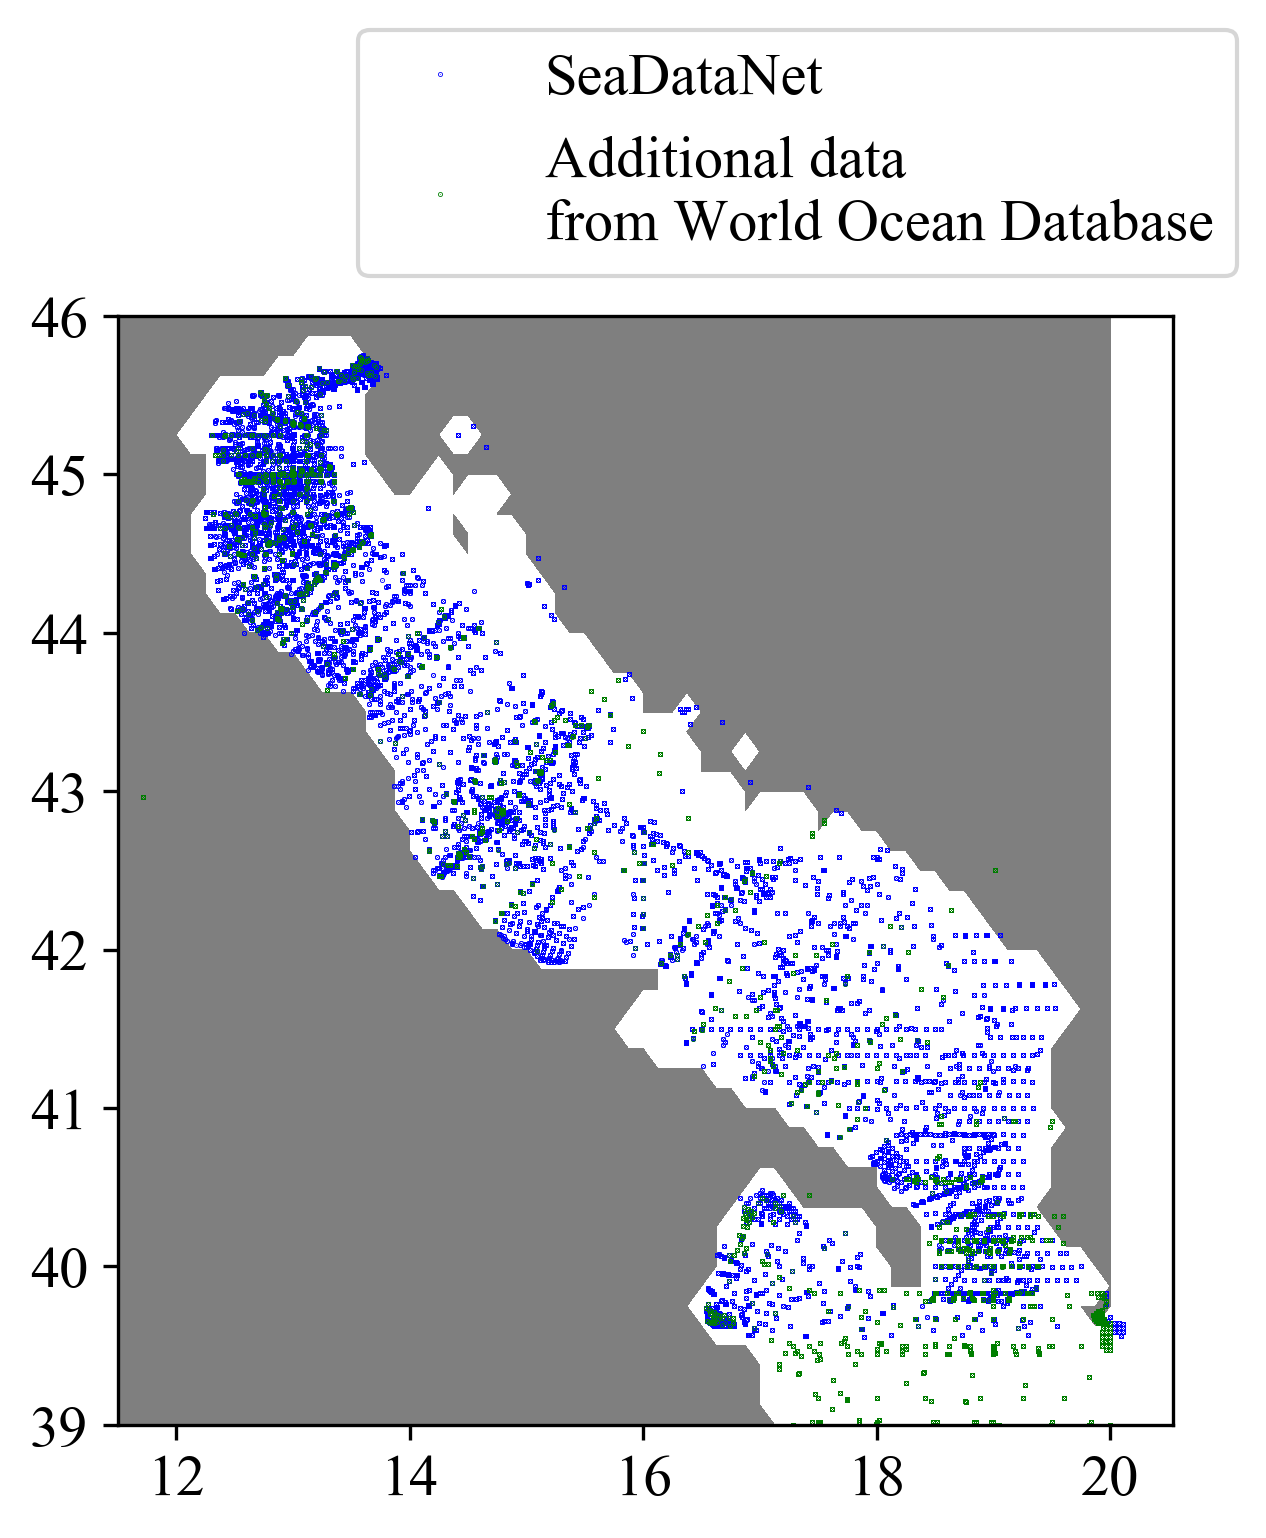

PyObject <matplotlib.legend.Legend object at 0x7fa7a805ed10>

In [26]:
figure()
contourf(bx, by, Float64.(mask_edit[:,:,1])',
    levels=[-1e5,0],cmap="binary"); 
plot(obslon, obslat, "bo", markersize=.2, label="SeaDataNet")
plot(obslonwod[newpoints], obslatwod[newpoints], "go", 
    markersize=.2, label="Additional data\nfrom World Ocean Database")
gca()[:set_aspect](aspect_ratio)
legend(loc=3, bbox_to_anchor=(0.2, 1.01))

## 4. Quality control
We check the salinity value.     
Adapt the criteria to your region and variable.

In [27]:
sel = (obsval .<= 40) .& (obsval .>= 25);

In [28]:
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsids = obsid[sel];

## 5. Parameters
### Modify data weight 
Compute the new weights that takes into account close points.     
If the dataset is large, this can take a few minutes.

In [29]:
?divand.weight_RtimesOne

```
 weights = weight_RtimesOne(x,len)
```

Compute the weight of the observations at location `x` to reduce the influence  of locally clustered data.  `x` is a tuple with n elements. Every element  represents a coordinate of the observations. `len` is a tuple of arrays representing the correlation length. `len[i]` is the correlation length in the  i-th dimension.


In [36]:
#rdiag=1.0./divand.weight_RtimesOne((obslon,obslat),(0.03,0.03));
#@show maximum(rdiag),mean(rdiag)

(maximum(rdiag), mean(rdiag)) = (236.24583280848483, 72.87784101224868)


(236.24583280848483, 72.87784101224868)

The maximal and mean values provide an indication of the spatial proximity between the data.
If you apply this technique, you need to adapt `epsilon2`:

In [ ]:
# epsilon2 = epsilon2 * rdiag

### Correlation lengths and noise-to-signal ratio

In [38]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(100_000.,sz)   # 100 km
leny = fill(100_000.,sz)   # 100 km
lenz = fill(25.,sz);      # 25 m 
len = (lenx, leny, lenz);
epsilon2 = 0.1;

### Output file name

In [39]:
filename = "Water_body_$(replace(varname,' ','_'))_Adriatic.4Danl.nc"

"Water_body_Salinity_Adriatic.4Danl.nc"

## 6. Metadata and attributes
Edit the different fields according to the project, the authors etc.

In [40]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet/EMODNet Chemistry Data Network",

    # Additional comment
    "comment" => "...",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # http://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "http://dx.doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...");

SeaDataNet global attributes:

In [41]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr)

(DataStructures.OrderedDict("project"=>"SeaDataCloud","institution"=>"University of Liege, GeoHydrodynamics and Environment Research","institution_urn"=>"SDN:EDMO::1579","Author_e-mail"=>"Your Name1 <name1@example.com>, Other Name <name2@example.com>","source"=>"observational data from SeaDataNet/EMODNet Chemistry Data Network","comment"=>"...","parameter_keyword"=>"Water body salinity","parameter_keyword_urn"=>"SDN:P35::EPC00001","search_keywords"=>"Salinity of the water column","search_keywords_urn"=>"SDN:P02::PSAL"…), DataStructures.OrderedDict("units"=>"1e-3","standard_name"=>"sea_water_salinity","long_name"=>"sea water salinity"))

## 7. Analysis
Remove the result file before running the analysis, otherwise you'll get the message     
```julia
NCDatasets.NetCDFError(13, "Permission denied")
```

In [49]:
if isfile(filename)
   rm(filename) # delete the previous analysis
end

### 7.1 Plotting function
Define a plotting function that will be applied for each time index and depth level. All the figures will be saved in a selected directory.

In [43]:
figdir = "./Adriatic/figures/"
if ~(isdir(figdir))
    mkdir(figdir)
else
    info("Figure directory already exists")
end

INFO: Figure directory already exists


In [51]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure(figsize = (10,8))
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)")
        pcolor(lonr-dx/2.,latr-dy/2,tmp[:,:,i]';
               vmin = 37, vmax = 39)
        colorbar(extend="both")
        contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
        gca()[:set_aspect](aspect_ratio)
        
        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        savefig(joinpath(figdir, figname));
    end
end

plotres (generic function with 1 method)

### 7.2 Create the gridded fields using `diva3d`
Here only the noise-to-signal ratio is estimated.     
Set `fitcorrlen` to `true` to also optimise the correlation length.

In [50]:
@time dbinfo = diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    plotres = plotres,
    mask = mask_edit,
    fitcorrlen = false,
    niter_e = 2,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib
    );

LoadError: [91mUndefVarError: dlon not defined[39m

Save the observation metadata in the NetCDF file

In [ ]:
divand.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid)

## 9. Apply a posteriori quality control
We can use the structure `dbinfo`.

## 10. XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project ("SeaDataCloud" or "EMODNET-chemistry")

In [ ]:
project = "SeaDataCloud";

Download CDI list

In [ ]:
cdilist = "CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip",cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [ ]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by _)
xmlfilename = "Water_body_$(replace(varname,' ','_')).4Danl.xml"

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [ ]:
# generate a XML file for Sextant (only for )
#divadoxml(filename,varname,project,cdilist,xmlfilename,
#          ignore_errors = ignore_errors)